# Análisis de datos mediante Python

In [1]:
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
user = 'root'
pw = 'RootSQL4703_'
host = 'localhost'
db = 'trafico_vehicular'

engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/{db}')

In [3]:
ciudades = pd.read_sql_table('ciudades',engine,index_col='city_id')
intercensal = pd.read_sql_table('intercensal',engine,index_col='city_id')
ct_ponderado = pd.read_sql_table('ct_ponderado',engine,index_col='city_id')
vtc_desglose = pd.read_sql_table('vtc_desglose',engine,index_col='city_id')
inversion = pd.read_sql_table('inversion',engine,index_col='city_id')

In [4]:
def sort_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = sorted(df.columns)
    classes = ['edad', 'transporte']
    cols = classes + [col for col in cols if col not in classes]
    return df[cols]

vtc_desglose = sort_columns(vtc_desglose)
intercensal = sort_columns(intercensal)

## Outliers

Empezamos con los valores atipicos. Nos aseguramos previamente de revisar valores faltantes y de tratar con ellos en el proceso ETL por lo que antes de describir los datos buscamos valores atipicos y sus causas. Esto puede ayudarnos más adelante ya que en caso de existir procesar de manera adecuada estos valores atipicos mejoran la robustez inicial de los análisis bi y multivariantes.

- Identificar Outliers

Buscaremos valores atipicos en las variables que nos explican el costo causado debido al trafico en las ciudades de México. Las variables asociadas al costo son las horas perdidas y el dinero perdido debido al trafico de cada ciudad. Estas variables nos ayudan a identificar la problematica y son la consecuencia del contexto de cada región, buscaremos los valores atipicos sobre estas variables.

El método utilizado para buscar los valores atípicos es identificar los datos que no se encuentran dentro del rango intercuartil. Este metodo proporciona una variable robusta a los valores atipicos y es facil de calcular dados los datos.

In [5]:
# Las variables de horas y costo monetario debido al trafico de cada ciudad
# se encuentran en la tabla ct_ponderado.

renames = {'costo_per_capita':'Costo', 'horas_per_capita':'Horas'}
ct = ct_ponderado.rename(columns=renames)

# Se calcula el IQR, y los cuartiles Q1 y Q3 para obtener el rango intercuartil

Q1_costo = ct['Costo'].quantile(0.25)
Q3_costo = ct['Costo'].quantile(0.75)
IQR_costo = Q3_costo - Q1_costo

Q1_horas = ct['Horas'].quantile(0.25)
Q3_horas = ct['Horas'].quantile(0.75)
IQR_horas = Q3_horas - Q1_horas

# Usando el rango intercuartil de cada variable se identifican los datos
# en cada variable que no se encuentren dentro del rango calculado, estos
# datos son los valores atipicos.

outliers_costo = ct[(ct['Costo'] < (Q1_costo - 1.5 * IQR_costo)) | (ct['Costo'] > (Q3_costo + 1.5 * IQR_costo))]

outliers_horas = ct[(ct['Horas'] < (Q1_horas - 1.5 * IQR_horas)) | (ct['Horas'] > (Q3_horas + 1.5 * IQR_horas))]

# Se muestran los datos atipicos obtenidos para cada variables

display(outliers_costo)
display(outliers_horas)

,Costo,Horas
city_id,,
29,5827.21,146.453


,Costo,Horas
city_id,,
29,5827.21,146.453


In [6]:
# Conociendo que la ciudad con el identificador "city_id" = 29 es un dato atipico en costos
# de tiempo y dinero debido al trafico identificamos la ciudad. 

# Usamos la tabla de ciudades y el identificador correcto. Este difiere del identificador
# de ciudad dado que el indice empieza en 0, a diferencia de 'city_id' que empieza en 1.

display(ciudades.iloc[28])

estado                       CDMX
ciudad            Valle de México
indice_trafico            1.47021
Name: 29, dtype: object

- Posibles Causas

Para ser procesado de manera correcta es necesario entender la causa de la existencia de este valor atipico. Revisamos las variables más generales que describen cada ciudad con el fin de investigar si esta variabilidad podría ser explicada por otras variables. Si la ciudad del valor atipico (CDMX) se encuentra entre las ciudades más destacadas en otros aspectos que podrían explicar el costo y el tiempo perdido debido al trafico entonces este resultado podría ser causado de forma natural en el contexto del país.

In [7]:
# Revisamos inicialmente las ciudades cuyo indice de trafico sea más alto

ciudades.sort_values(by='indice_trafico', ascending=False).head(5)

,estado,ciudad,indice_trafico
city_id,,,
29,CDMX,Valle de México,1.47021
20,Puebla,Puebla-Tlaxcala,1.45910
15,Nuevo León,Monterrey,1.44575
27,Edo Mex,Toluca,1.43861
21,Queretaro,Querétaro,1.43151


In [8]:
# Las poblaciones, en especial las que se trasladan, suele impicar una mayor perdida individual
# de costo y tiempo debido al trafico. Debido a esto revisamos los valores más altos de población
# entre las entidades federativas.

int2 = intercensal.loc[:,:'pob_zm']
int2['pob_traslado'] = int2['pob_traslado_escuela'] + int2['pob_traslado_trabajo']

aggregation ={'pob_zm':'first',
              'pob_traslado_escuela':'sum',
              'pob_traslado_trabajo':'sum',
              'pob_traslado':'sum'}

int3 = int2.groupby('city_id')[list(aggregation.keys())].agg(aggregation)
int3.sort_values(by='pob_traslado', ascending=False).head()

,pob_zm,pob_traslado_escuela,pob_traslado_trabajo,pob_traslado
city_id,,,,
29,20892724,2484839,5588264,8073103
11,4796603,661225,1424798,2086023
15,4475949,610419,1398987,2009406
20,2941988,398773,733968,1132741
25,1840710,296170,598171,894341


- Conclusión de los Outliers
  
Se identifico a la Ciudad de México como un valor atipico de costo debido al trafico. Dado que su descripción en variables como el indice de trafico, la poblaciñon de la zona metropolitana o la población que se traslada es la más alta entre las ciudades de México se podría explicar el valor atipico como una consecuencia natural que describe al país. Por lo tanto, la Ciudad de México se mantendra como parte de la población de ciudades de México a considerar en los siguentes análisis.

## Univariate Analysis

Utilizamos estadistica descripitiva sobre una variable a al vez para entender los datos registrados en nuestra base de datos. Es de mayor interes entender principalmente la distribución del costo generado debido al trafico y de las variables más generales que describan a cada ciudad.

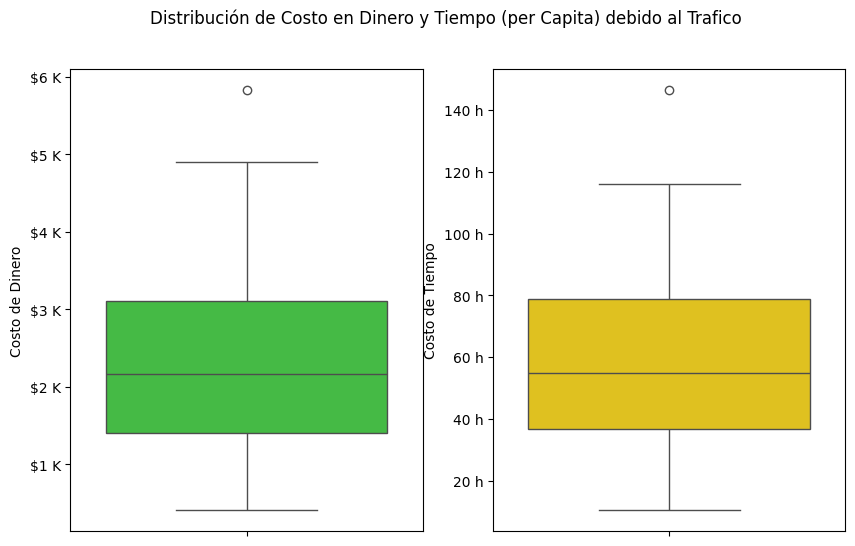

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Distribución de Costo en Dinero y Tiempo (per Capita) debido al Trafico')

# Listas de colores y categorias (variables) a dibujar

colors = ['limegreen', 'gold']
cat = ['Dinero', 'Tiempo']

# Por cada variable dibujamos la caja y le damos el nombre al eje Y
for i, col in enumerate(ct_ponderado.columns):
    sns.boxplot(data=ct_ponderado, y=col, ax= ax[i], legend=False, color=colors[i])
    ax[i].set_ylabel('Costo de ' + cat[i])

# Se cambia el formato de los valores en el eje Y para cada una de las gráficas
# en la figura

ax[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)} K'))
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y)} h'))

plt.show()

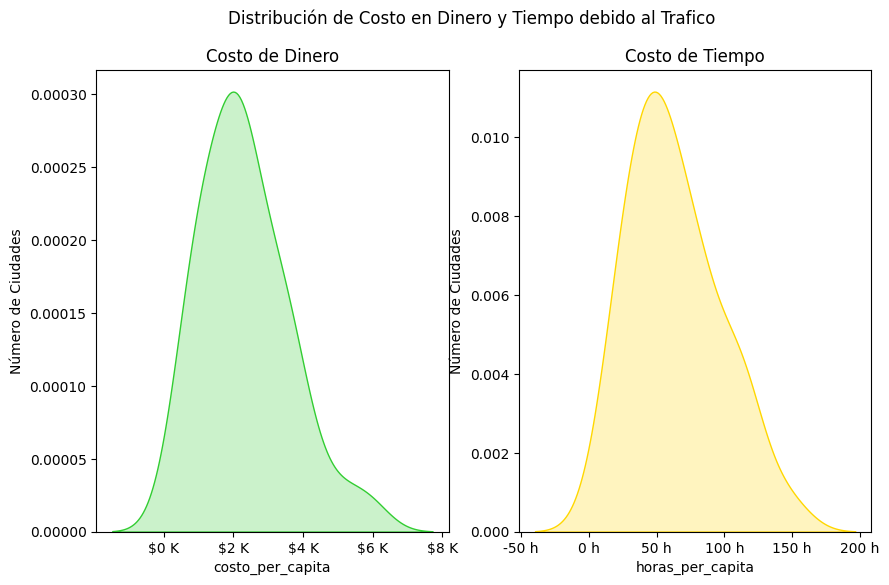

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Distribución de Costo en Dinero y Tiempo debido al Trafico')

cat = ['Dinero', 'Tiempo']
colors = ['limegreen', 'gold']

for i, col in enumerate(ct_ponderado.columns):
    # sns.histplot(data=ct_ponderado, x=col, bins=10, ax= ax[i], color=colors[i])
    sns.kdeplot(data=ct_ponderado, x=col, fill=True, ax=ax[i], color=colors[i])
    ax[i].set_title(f'Costo de {cat[i]}')
    ax[i].set_ylabel('Número de Ciudades')

ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)} K'))
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'{int(y)} h'))

plt.show()

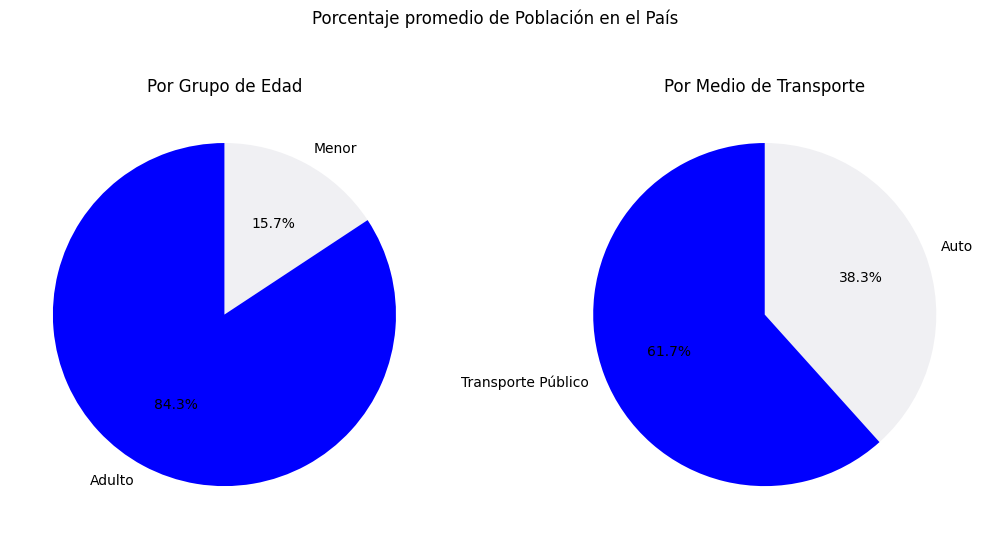

In [11]:
# Graficamos graficas de pastel para entender la distribución tipica de las ciudades
# respecto al porcentaje de las poblaciones por grupo de edad y por medio de transporte
# usado.

# Copiamos la tabla intercensal con las columnas de interes y creamos una nueva 
# columna con el valor de la población que se traslada de acuerdo con la encuesta
# intercensal

inter = intercensal.iloc[:,:7]
inter['pob_traslado'] = inter['pob_traslado_escuela']+inter['pob_traslado_trabajo']
inter = inter[['edad','transporte','pob_traslado']]

# Definimos listas para usarlas en las graficas. Estas contienen los nombres de la 
# categoria de cada grafica y el nombre de cada porción en las graficas de pastel

categoria = ['Grupo de Edad','Medio de Transporte']
label = [['Menor', 'Adulto'],
         ['Auto', 'Transporte Público']]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Porcentaje promedio de Población en el País')

for i, col in enumerate(['edad', 'transporte']):
    interi = inter.groupby(['city_id', col])['pob_traslado'].sum()
    interi = interi.groupby(col).mean()
    ax[i].pie(interi, labels=label[i], autopct='%1.1f%%', startangle=90, counterclock=False, colors=sns.color_palette('light:b', n_colors=2))
    ax[i].set_title(f'Por {categoria[i]}')

plt.tight_layout()
plt.show()

## Análisis Multivariable

Buscamos pincipalmente relaciones a priori entre las variables más importantes, y las posibles formas que toman los patrones o relaciones. Para las correlaciones calculamos algún coeficiente de correlación para identificar los posibles patrones entre los pares de variables.

In [12]:
# Con el fin de buscar posibles relaciones entre los grupos de edad, medio de transporte y las poblaciones
# en cada clasificación, y el costo debido al trafico en cada grupo se utiliza la tabla vtc_desglose.

# Copiamos la tabla para no modificar la tabla original
vtc = vtc_desglose.copy()

# Convertimos las variables categoricas en númericas
vtc[['edad','transporte']] = vtc[['edad','transporte']].apply(lambda x : pd.factorize(x)[0])

# Para organizar mejor las columnas creamos una lista con las columnas que nos interesa
# fijar al inicio con el orden deseado
cols = ['edad', 'transporte', 'costo_congestion_capita', 'horas_persona_capita']
# agregamos a la lista las columnas no consideradas antes
cols += [e for e in vtc.columns if e not in cols]
# Actualizamos el orden de las columnas
vtc = vtc[cols]

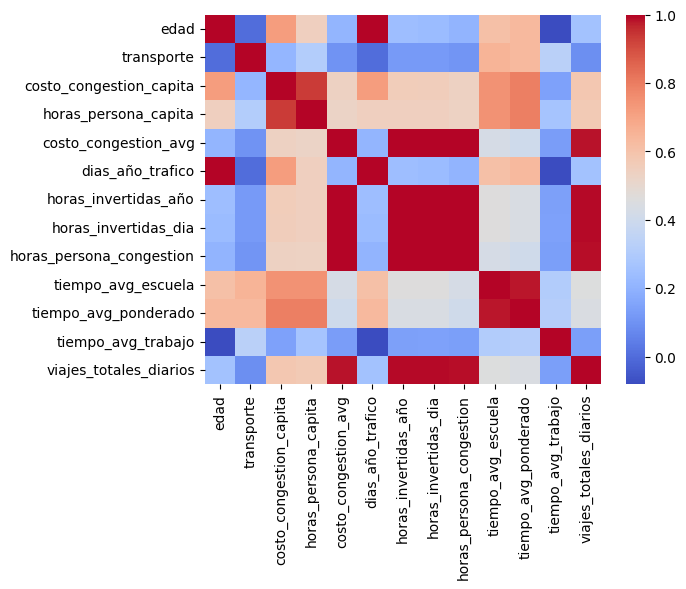

In [13]:
# Calculamos la matriz de correlación
correlation = vtc.corr()

# Graficamos la matriz de correlación como un mapa de calor
sns.heatmap(correlation, cmap='coolwarm')
plt.show()

Destacamos entre los resultados valores altos de correlación entre la edad con variables como el costo monetario, las horas perdidas por persona, y el tiempo promedio perdido. Estos resultados se repiten de forma similar para la variable transporte (medio de transporte) con la diferencia en que se registran valores menores en los pares con las variables de costo monetario y horas perdidas en distinción con los grupos de edad.

Se concluye que la variabilidad del costo debido al trafico, tanto monetario como de tiempo, puede explicarse en cierta medida debido a la variabilidad de los grupos de edad y el medio de transporte utilizado en las ciudades de México.

In [ ]:
# Buscamos conocer si existe correlación entre entre el tamaño de la población y el costo debido al trafico.

# Las poblaciones se encuentran en la tabla intercensal por lo que copiamos la tabla para
# no modificar la tabla original, solo en las columnas de interés. 
pob_costo = intercensal[['edad','transporte','pob_traslado_escuela','pob_traslado_trabajo', 'pob_zm']].copy()

# Unimos la tabla intercensal con las tablas de ciudades y de ct_ponderado que contienen las variables
# que describen el trafico de las ciudades con el indice de trafico, el costo monetario y el tiempo
# perdido debido al trafico
pob_costo = pd.merge(pob_costo, pd.merge(ciudades['indice_trafico'], ct_ponderado, on='city_id'), on='city_id')

# Convertimos las variables cualitativas a variables cuantitativas
pob_costo[['edad','transporte']] = pob_costo[['edad','transporte']].apply(lambda x: pd.factorize(x)[0])

# pob_costo = pob_costo.sort_values(by=['city_id', 'edad', 'transporte'])

# Agregamos una columna que suma los valores de las poblaciones de traslado en la columna pob_traslado
pob_costo.insert(loc=4, column='pob_traslado', value= pob_costo['pob_traslado_escuela']+pob_costo['pob_traslado_trabajo'])

# Agrupa los valores de cada grupo poblacional sumando por cada ciudad
# y las columnas restantes se pasa el valor correspondiente de cada ciudad
# usando la función first.

# Lista de columnas de poblaciones
cols = ['pob_traslado_escuela', 'pob_traslado_trabajo', 'pob_traslado']
# Diccionario con las columnas de poblaciones y la función sum como método de agrupación
agg_cols = {e:'sum' for e in cols}
# Agrega las columnas edad y transporte a la lista de columnas
cols += ['edad', 'transporte']
# Agrega al diccionario las columnas restantes con la función 'first' 
# excepto las columnas edad y transporte
agg_cols.update({e:'first' for e in pob_costo.columns if e not in cols})

# Agrega las columnas por ciudad
pob_costo = pob_costo.groupby('city_id')[list(agg_cols.keys())].agg(agg_cols)

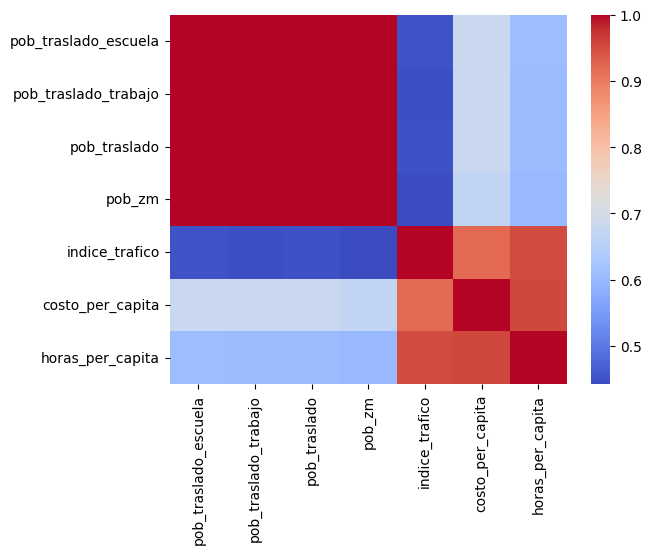

In [15]:
cor = pob_costo.corr()

sns.heatmap(cor,cmap='coolwarm')
plt.show()

Se puede observar valores relativos a 0.7 en los coeficientes de correlación que relacionan las distintas variables poblacionales con las variables debido al trafico. Se destaca sin embargo que el valor se reduce en los pares que involucran el indice de trafico. En general se puede concluir que la variabilidad de las consecuencias del trafico se explican por la variabilidad en el tamaño de las poblaciones en las ciudades.

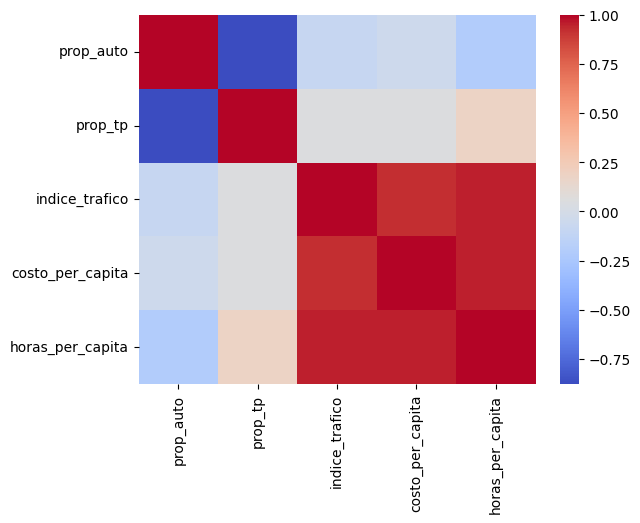

In [ ]:
# De forma similar a lo que se realizo con la población buscamos si existe relación entre las 
# proporciones de automoviles y transporte público de las ciudades con el trafico de las mismas.

# Unimos las tablas que contienen las proporciones de los medios de transporte, el indice de trafico
# , el costo monetario y el tiempo perdido debido al trafico.
prop = pd.merge(inversion.iloc[:,:2], pd.merge(ciudades['indice_trafico'], ct_ponderado, on='city_id'), on='city_id')

# Calculamos la matriz de correlación
cor = prop.corr()

# Graficamos la matriz como un mapa de calor
sns.heatmap(cor,cmap='coolwarm')
plt.show()

Se observan valores bajos entre los pares de (variables de proporción, variables de trafico), lo que indica que no existe evidencia de correlación entre las variables. Intuitivamente, las proporciones de cada medio de transporte usado no son suficiente para explicar el trafico, en ese aspecto tiene mayor relevancia el tamaño de cada población.

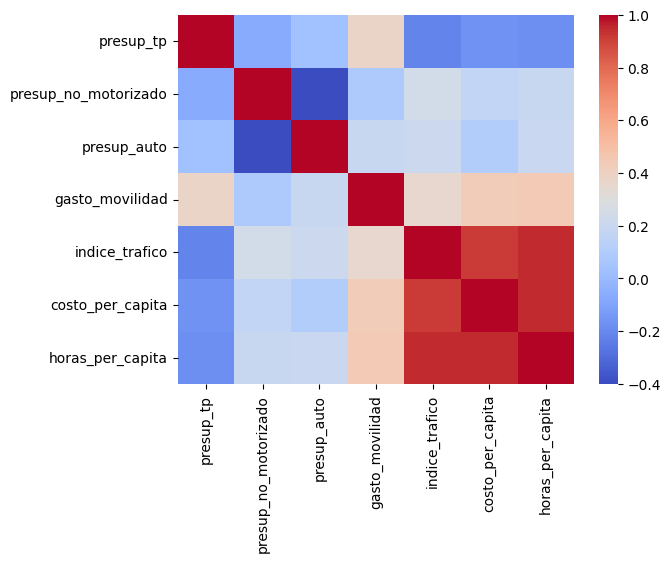

In [ ]:
# Considerando una posible relación entre el presupuesto en movilidad y las variables
# debido al trafico.

# Unimos las tablas con presupuesto en movilidad, indice de trafico y el costo de cada ciudad.
# En este caso se consideran solo las ciudades cuyo presupuesto publico se conoce y se usa 
# la union por la izquierda para considerar solo estas ciudades.
gasto = pd.merge(inversion.iloc[:,2:].dropna(), pd.merge(ciudades['indice_trafico'], ct_ponderado, on='city_id'), on='city_id', how='left')

# Se calcula la matriz de correlación
cor = gasto.corr()

sns.heatmap(cor,cmap='coolwarm')
plt.show()

Se destaca principalmente el gasto de movilidad como una variable relevante en el trafico de las ciudades. Los valores en estos pares de variables son cercanos al 0.4 por lo que son relativamente bajos indicando una correlación medianamente fuerte entre estas. Podemos tomar estos resultados como evidencia que indica la relación entre estas variables pero es necesario realizar más análisis con el fin de llegar a resultados conclusivos.